# Grad-CAM Visualization

---



In [0]:
#upload images compressed as tar

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving tub_data.tar to tub_data.tar
User uploaded file "tub_data.tar" with length 16317440 bytes


In [0]:
!tar -xf tub_data.tar

In [0]:
#upload model file

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving mypilot to mypilot
User uploaded file "mypilot" with length 3267552 bytes


In [0]:
ls

mypilot  sample_data/  tub/  tub_data.tar


In [0]:
!pip install keras-vis

In [0]:
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

def default_linear():
    img_in = Input(shape=(120, 160, 3), name='img_in')
    x = img_in

    # Convolution2D class name is an alias for Conv2D
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    x = Dense(units=50, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)

    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.5, 'throttle_out': .5})

    return model

Using TensorFlow backend.


In [0]:
import re 
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [0]:
model = default_linear()
#model.load_weights('donkeycar_model.h5')
model.load_weights('mypilot')
#model.summary()

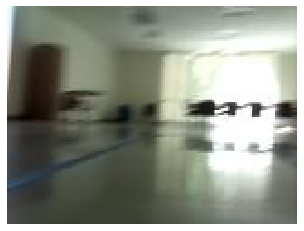

In [0]:
import numpy as np
import time

from matplotlib import pyplot as plt
from glob import iglob
%matplotlib inline

#from model import build_model, FRAME_W, FRAME_H
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay

FRAME_H = 120
FRAME_W = 160

IMG_PATH = 'tub/1710_cam-image_array_.jpg'

#model = default_linear()
#model.load_weights('mypilot')
img = utils.load_img(IMG_PATH, target_size=(FRAME_H, FRAME_W))
#plt.figure(figsize=(15, 45))
plt.grid(False)
#plt.xlabel('px')
#plt.ylabel('px')
#plt.title('Camera Image')
#plt.imshow(img)

# Convert to BGR, create input with batch_size: 1.
#bgr_img = utils.bgr2rgb(img)
#plt.imshow(bgr_img)
plt.imshow(img)
#plt.xlabel('px')
#plt.ylabel('px')
plt.xticks([])
plt.yticks([])
#plt.title(IMG_PATH[4:])
plt.savefig('resultImage.png')
img_input = np.expand_dims(img_to_array(img), axis=0)
#print('Predicted {}'.format(pred))
heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, seed_input=img_input, grad_modifier='small_values')

plt.figure()
#plt.grid(False)
#plt.xlabel('px')
#plt.ylabel('px')
#plt.title('Gradient-weighted Class Activation Mapping')
# Overlay is used to alpha blend heatmap onto img.
#plt.imshow(overlay(img, heatmap, alpha=0.7))

In [0]:
from google.colab import files
files.download('resultImage.png')

[-0.14291976]


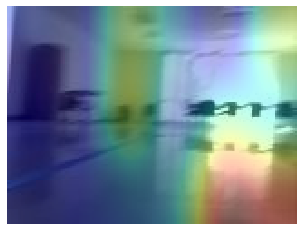

In [0]:
pred = model.predict(img_input)[0][0]
print(pred)
plt.figure()
#plt.title(IMG_PATH[4:] + ' (Grad-CAM)')
plt.xticks([])
plt.yticks([])
# Overlay is used to alpha blend heatmap onto img.
plt.imshow(overlay(img, heatmap, alpha=0.7))
plt.savefig('resultImageCAM.png')

In [0]:
from google.colab import files
files.download('resultImageCAM.png')